In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import XGBModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [2]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [3]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [4]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    target_lags_list = [-i for i in range(1, 16)]
    xgb_params = {
        'n_estimators': 300,
        'max_depth': 3,
        'learning_rate': 0.03204910598309296,
        'min_child_weight': 6,
        'subsample': 0.6,
        'colsample_bytree': 0.8,
        'gamma': 0.0,
        'reg_alpha': 1.88047545015871774e-05,
        'reg_lambda': 0.1811980297044638,
        'n_jobs': -1
    }

    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    scaler = scaler.fit(train_fold)
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)

    model = XGBModel(
        lags=target_lags_list,
        output_chunk_length=1,
        add_encoders=encoders,
        **xgb_params
    )

    model.fit(
        series=train_scaled,
        val_series=val_scaled,
    )
    
    forecasts = model.historical_forecasts(
        val_scaled,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")


Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples
[0]	validation_0-rmse:0.37928
[1]	validation_0-rmse:0.37138
[2]	validation_0-rmse:0.36379
[3]	validation_0-rmse:0.35661
[4]	validation_0-rmse:0.34965
[5]	validation_0-rmse:0.34304
[6]	validation_0-rmse:0.33650
[7]	validation_0-rmse:0.33027
[8]	validation_0-rmse:0.32431
[9]	validation_0-rmse:0.31878
[10]	validation_0-rmse:0.31338
[11]	validation_0-rmse:0.30781
[12]	validation_0-rmse:0.30262
[13]	validation_0-rmse:0.29769
[14]	validation_0-rmse:0.29311
[15]	validation_0-rmse:0.28845
[16]	validation_0-rmse:0.28404
[17]	validation_0-rmse:0.27978
[18]	validation_0-rmse:0.27568
[19]	validation_0-rmse:0.27179
[20]	validation_0-rmse:0.26813
[21]	validation_0-rmse:0.26446
[22]	validation_0-rmse:0.26107
[23]	validation_0-rmse:0.25782
[24]	validation_0-rmse:0.25476
[25]	validation_0-rmse:0.25159
[26]	validation_0-rmse:0.24855
[27]	validation_0-rmse:0.24577
[28]	validation_0-rmse:0.24324
[29]	validation_0-rmse:0.24

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


[0]	validation_0-rmse:20.40105
[1]	validation_0-rmse:20.39551
[2]	validation_0-rmse:20.39011
[3]	validation_0-rmse:20.38509
[4]	validation_0-rmse:20.38010
[5]	validation_0-rmse:20.37533
[6]	validation_0-rmse:20.37065
[7]	validation_0-rmse:20.36613
[8]	validation_0-rmse:20.36176
[9]	validation_0-rmse:20.35933
[10]	validation_0-rmse:20.35532
[11]	validation_0-rmse:20.35142
[12]	validation_0-rmse:20.34773
[13]	validation_0-rmse:20.34404
[14]	validation_0-rmse:20.34036
[15]	validation_0-rmse:20.33687
[16]	validation_0-rmse:20.33522
[17]	validation_0-rmse:20.33188
[18]	validation_0-rmse:20.32866
[19]	validation_0-rmse:20.32564
[20]	validation_0-rmse:20.32262
[21]	validation_0-rmse:20.31970
[22]	validation_0-rmse:20.31694
[23]	validation_0-rmse:20.31420
[24]	validation_0-rmse:20.31288
[25]	validation_0-rmse:20.31038
[26]	validation_0-rmse:20.30787
[27]	validation_0-rmse:20.30546
[28]	validation_0-rmse:20.30432
[29]	validation_0-rmse:20.30307
[30]	validation_0-rmse:20.30089
[31]	validation_0-

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.




Treinando o modelo...
Train set: 3119 samples
Validation set: 1038 samples
[0]	validation_0-rmse:0.37729
[1]	validation_0-rmse:0.36525
[2]	validation_0-rmse:0.35370
[3]	validation_0-rmse:0.34244
[4]	validation_0-rmse:0.33163
[5]	validation_0-rmse:0.32109
[6]	validation_0-rmse:0.31105
[7]	validation_0-rmse:0.30125
[8]	validation_0-rmse:0.29173
[9]	validation_0-rmse:0.28258
[10]	validation_0-rmse:0.27362
[11]	validation_0-rmse:0.26495
[12]	validation_0-rmse:0.25667
[13]	validation_0-rmse:0.24847
[14]	validation_0-rmse:0.24063
[15]	validation_0-rmse:0.23303
[16]	validation_0-rmse:0.22561
[17]	validation_0-rmse:0.21852
[18]	validation_0-rmse:0.21162
[19]	validation_0-rmse:0.20506
[20]	validation_0-rmse:0.19866
[21]	validation_0-rmse:0.19243
[22]	validation_0-rmse:0.18637
[23]	validation_0-rmse:0.18097
[24]	validation_0-rmse:0.17552
[25]	validation_0-rmse:0.16996
[26]	validation_0-rmse:0.16463
[27]	validation_0-rmse:0.15957
[28]	validation_0-rmse:0.15468
[29]	validation_0-rmse:0.15023
[30

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.



Fold 4

Treinando o modelo...
Train set: 4157 samples
Validation set: 1038 samples
[0]	validation_0-rmse:0.39991
[1]	validation_0-rmse:0.38769
[2]	validation_0-rmse:0.37574
[3]	validation_0-rmse:0.36427
[4]	validation_0-rmse:0.35310
[5]	validation_0-rmse:0.34229
[6]	validation_0-rmse:0.33181
[7]	validation_0-rmse:0.32173
[8]	validation_0-rmse:0.31175
[9]	validation_0-rmse:0.30221
[10]	validation_0-rmse:0.29303
[11]	validation_0-rmse:0.28415
[12]	validation_0-rmse:0.27558
[13]	validation_0-rmse:0.26724
[14]	validation_0-rmse:0.25913
[15]	validation_0-rmse:0.25125
[16]	validation_0-rmse:0.24370
[17]	validation_0-rmse:0.23636
[18]	validation_0-rmse:0.22933
[19]	validation_0-rmse:0.22255
[20]	validation_0-rmse:0.21597
[21]	validation_0-rmse:0.20955
[22]	validation_0-rmse:0.20336
[23]	validation_0-rmse:0.19737
[24]	validation_0-rmse:0.19160
[25]	validation_0-rmse:0.18593
[26]	validation_0-rmse:0.18051
[27]	validation_0-rmse:0.17517
[28]	validation_0-rmse:0.17013
[29]	validation_0-rmse:0.16

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


[0]	validation_0-rmse:0.39205
[1]	validation_0-rmse:0.37996
[2]	validation_0-rmse:0.36830
[3]	validation_0-rmse:0.35706
[4]	validation_0-rmse:0.34603
[5]	validation_0-rmse:0.33536
[6]	validation_0-rmse:0.32508
[7]	validation_0-rmse:0.31521
[8]	validation_0-rmse:0.30550
[9]	validation_0-rmse:0.29607
[10]	validation_0-rmse:0.28704
[11]	validation_0-rmse:0.27837
[12]	validation_0-rmse:0.26973
[13]	validation_0-rmse:0.26163
[14]	validation_0-rmse:0.25374
[15]	validation_0-rmse:0.24584
[16]	validation_0-rmse:0.23819
[17]	validation_0-rmse:0.23113
[18]	validation_0-rmse:0.22398
[19]	validation_0-rmse:0.21706
[20]	validation_0-rmse:0.21056
[21]	validation_0-rmse:0.20402
[22]	validation_0-rmse:0.19775
[23]	validation_0-rmse:0.19181
[24]	validation_0-rmse:0.18588
[25]	validation_0-rmse:0.18023
[26]	validation_0-rmse:0.17473
[27]	validation_0-rmse:0.16956
[28]	validation_0-rmse:0.16443
[29]	validation_0-rmse:0.15953
[30]	validation_0-rmse:0.15463
[31]	validation_0-rmse:0.14998
[32]	validation_0-

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.



Fold 6

Treinando o modelo...
Train set: 6233 samples
Validation set: 1038 samples
[0]	validation_0-rmse:0.38509
[1]	validation_0-rmse:0.37465
[2]	validation_0-rmse:0.36482
[3]	validation_0-rmse:0.35534
[4]	validation_0-rmse:0.34601
[5]	validation_0-rmse:0.33690
[6]	validation_0-rmse:0.32835
[7]	validation_0-rmse:0.32012
[8]	validation_0-rmse:0.31240
[9]	validation_0-rmse:0.30475
[10]	validation_0-rmse:0.29736
[11]	validation_0-rmse:0.29036
[12]	validation_0-rmse:0.28374
[13]	validation_0-rmse:0.27736
[14]	validation_0-rmse:0.27103
[15]	validation_0-rmse:0.26491
[16]	validation_0-rmse:0.25913
[17]	validation_0-rmse:0.25362
[18]	validation_0-rmse:0.24819
[19]	validation_0-rmse:0.24325
[20]	validation_0-rmse:0.23843
[21]	validation_0-rmse:0.23388
[22]	validation_0-rmse:0.22953
[23]	validation_0-rmse:0.22537
[24]	validation_0-rmse:0.22122
[25]	validation_0-rmse:0.21725
[26]	validation_0-rmse:0.21334
[27]	validation_0-rmse:0.20976
[28]	validation_0-rmse:0.20626
[29]	validation_0-rmse:0.20

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


[0]	validation_0-rmse:0.33399
[1]	validation_0-rmse:0.32559
[2]	validation_0-rmse:0.31739
[3]	validation_0-rmse:0.30945
[4]	validation_0-rmse:0.30192
[5]	validation_0-rmse:0.29466
[6]	validation_0-rmse:0.28754
[7]	validation_0-rmse:0.28087
[8]	validation_0-rmse:0.27452
[9]	validation_0-rmse:0.26839
[10]	validation_0-rmse:0.26257
[11]	validation_0-rmse:0.25690
[12]	validation_0-rmse:0.25153
[13]	validation_0-rmse:0.24633
[14]	validation_0-rmse:0.24151
[15]	validation_0-rmse:0.23684
[16]	validation_0-rmse:0.23227
[17]	validation_0-rmse:0.22785
[18]	validation_0-rmse:0.22359
[19]	validation_0-rmse:0.21955
[20]	validation_0-rmse:0.21579
[21]	validation_0-rmse:0.21213
[22]	validation_0-rmse:0.20880
[23]	validation_0-rmse:0.20556
[24]	validation_0-rmse:0.20245
[25]	validation_0-rmse:0.19970
[26]	validation_0-rmse:0.19678
[27]	validation_0-rmse:0.19407
[28]	validation_0-rmse:0.19159
[29]	validation_0-rmse:0.18915
[30]	validation_0-rmse:0.18685
[31]	validation_0-rmse:0.18468
[32]	validation_0-

In [5]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


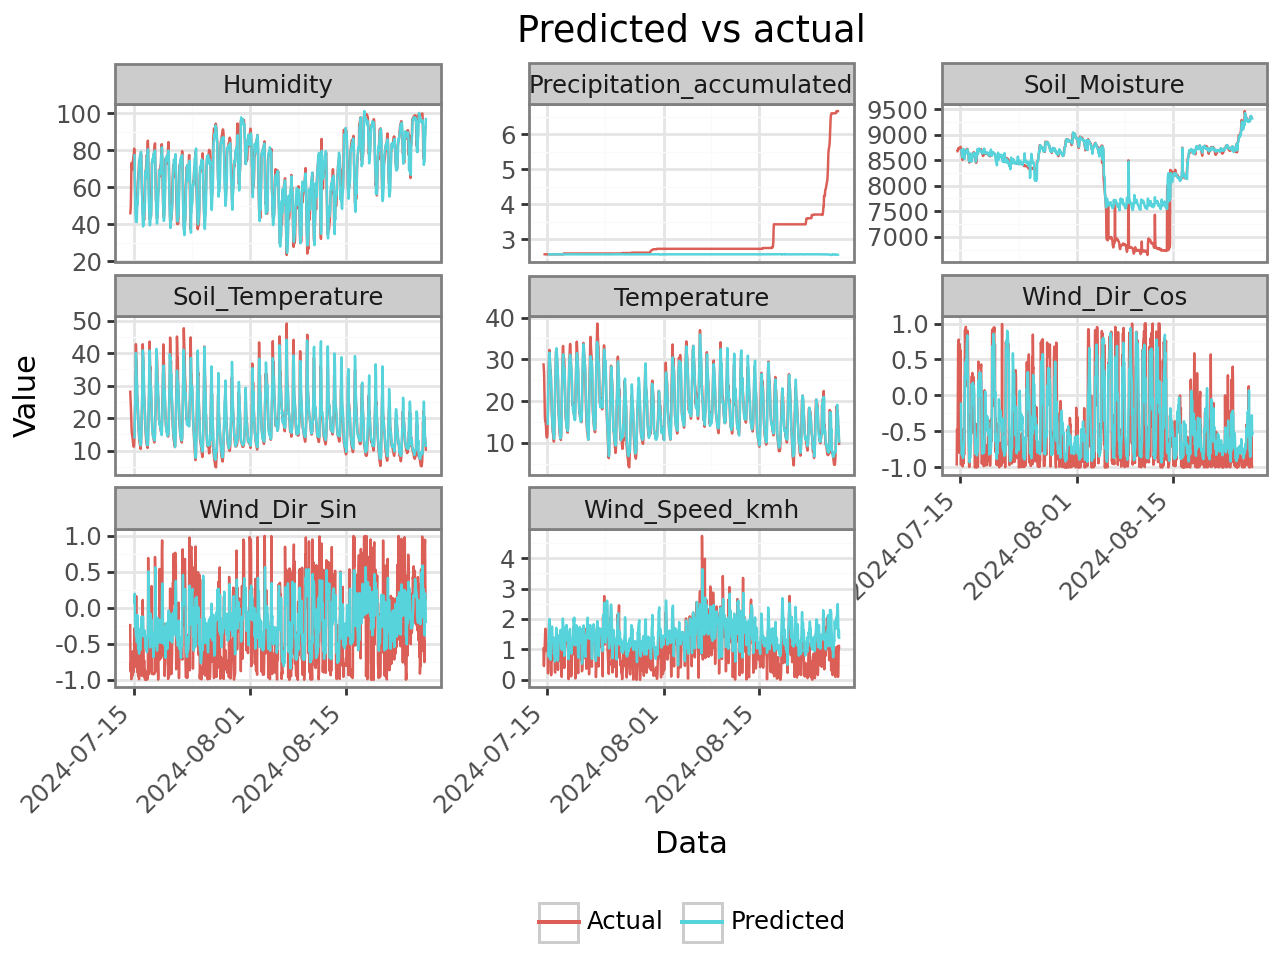

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual.png


In [6]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot.show()
plot.save('predict_actual.png', width=12, height=10, dpi=300)

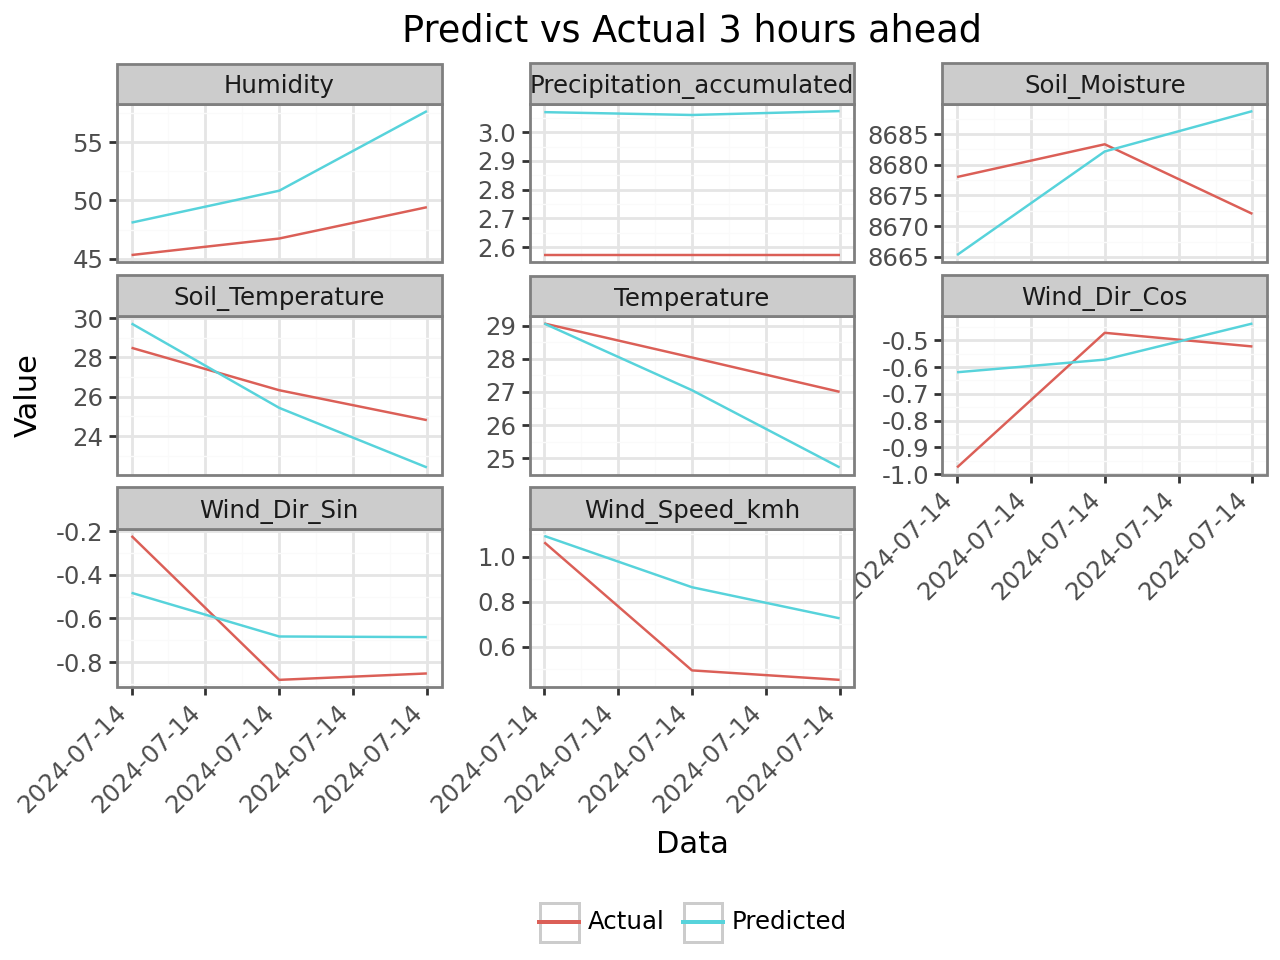

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/XGB/predict_3.png
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide


{'Temperature': {'MSE': np.float64(2.0654224435260526), 'RMSE': np.float64(1.437157765704953), 'MAE': np.float64(1.0916716512044253), 'R2': np.float64(-1.9096561423318068), 'SMAPE': np.float64(4.143053315301945)}, 'Precipitation_accumulated': {'MSE': np.float64(0.24495014490483039), 'RMSE': np.float64(0.49492438301707303), 'MAE': np.float64(0.4948915849308344), 'R2': np.float64(-inf), 'SMAPE': np.float64(17.548907211287574)}, 'Humidity': {'MSE': np.float64(31.054669579646816), 'RMSE': np.float64(5.572671673411849), 'MAE': np.float64(5.059279378255208), 'R2': np.float64(-9.654122084671169), 'SMAPE': np.float64(9.952100831983833)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.07081684923942648), 'RMSE': np.float64(0.266114353689211), 'MAE': np.float64(0.22395544926325486), 'R2': np.float64(0.08992966519071355), 'SMAPE': np.float64(34.519778389637914)}, 'Soil_Moisture': {'MSE': np.float64(147.6081098273953), 'RMSE': np.float64(12.149407797394707), 'MAE': np.float64(10.20258246527798), 'R2': np.

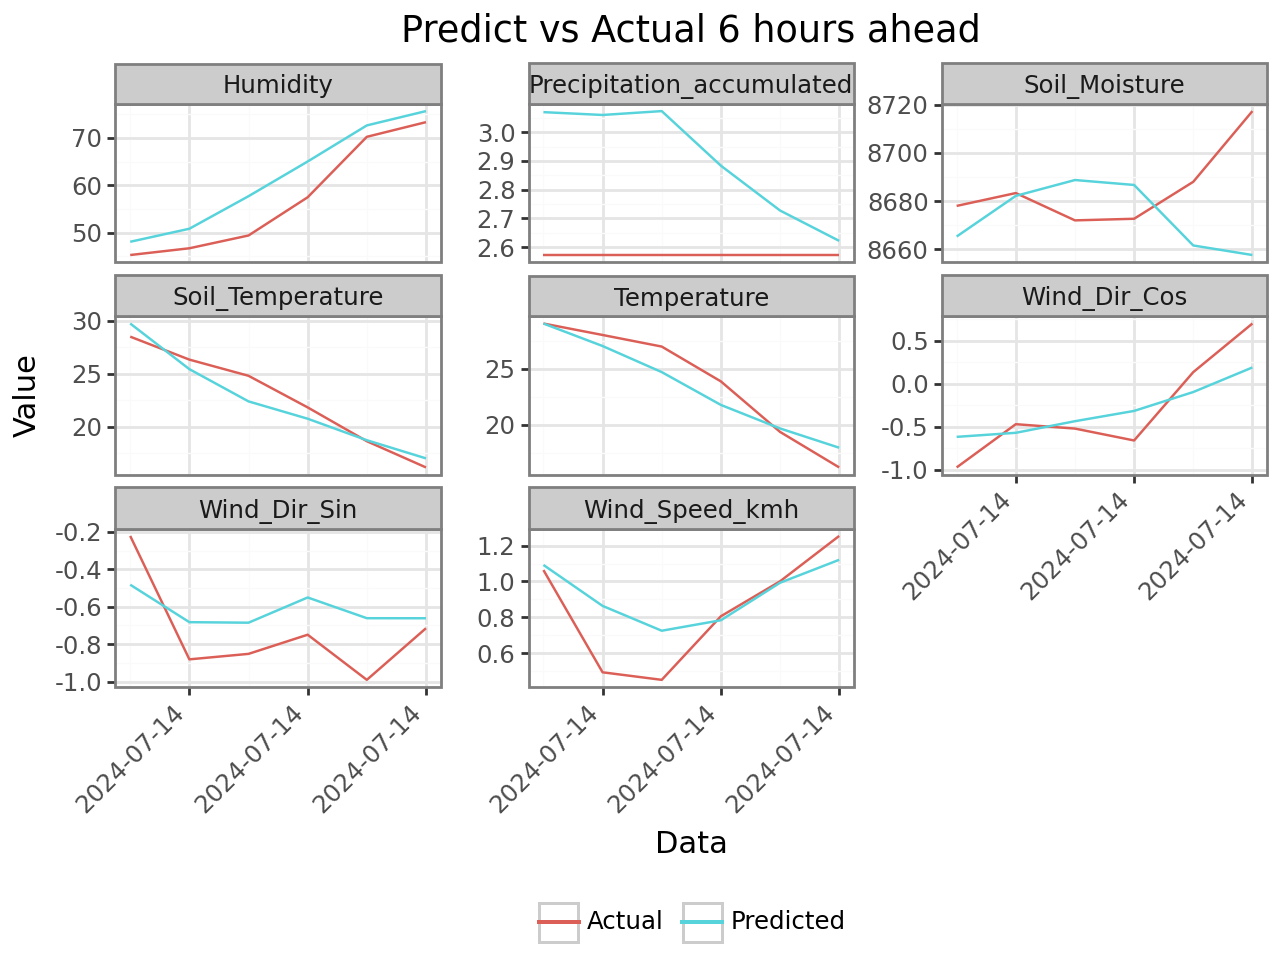

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/XGB/predict_6.png


{'Temperature': {'MSE': np.float64(2.305504547250876), 'RMSE': np.float64(1.5183887997646968), 'MAE': np.float64(1.2421390321519628), 'R2': np.float64(0.8963646595626265), 'SMAPE': np.float64(5.593713277923683)}, 'Precipitation_accumulated': {'MSE': np.float64(0.14295967755408587), 'RMSE': np.float64(0.37810008933361267), 'MAE': np.float64(0.33322217168213647), 'R2': np.float64(-7.248916842394843e+29), 'SMAPE': np.float64(11.961761991747418)}, 'Humidity': {'MSE': np.float64(26.85223430971517), 'RMSE': np.float64(5.181914154992841), 'MAE': np.float64(4.57370825873481), 'R2': np.float64(0.7822521918309069), 'SMAPE': np.float64(8.108345649114245)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.03845106473989877), 'RMSE': np.float64(0.1960894304645173), 'MAE': np.float64(0.13917558206452266), 'R2': np.float64(0.5547765574885553), 'SMAPE': np.float64(19.72543007378646)}, 'Soil_Moisture': {'MSE': np.float64(816.9531071980946), 'RMSE': np.float64(28.58239155840698), 'MAE': np.float64(21.791015625000

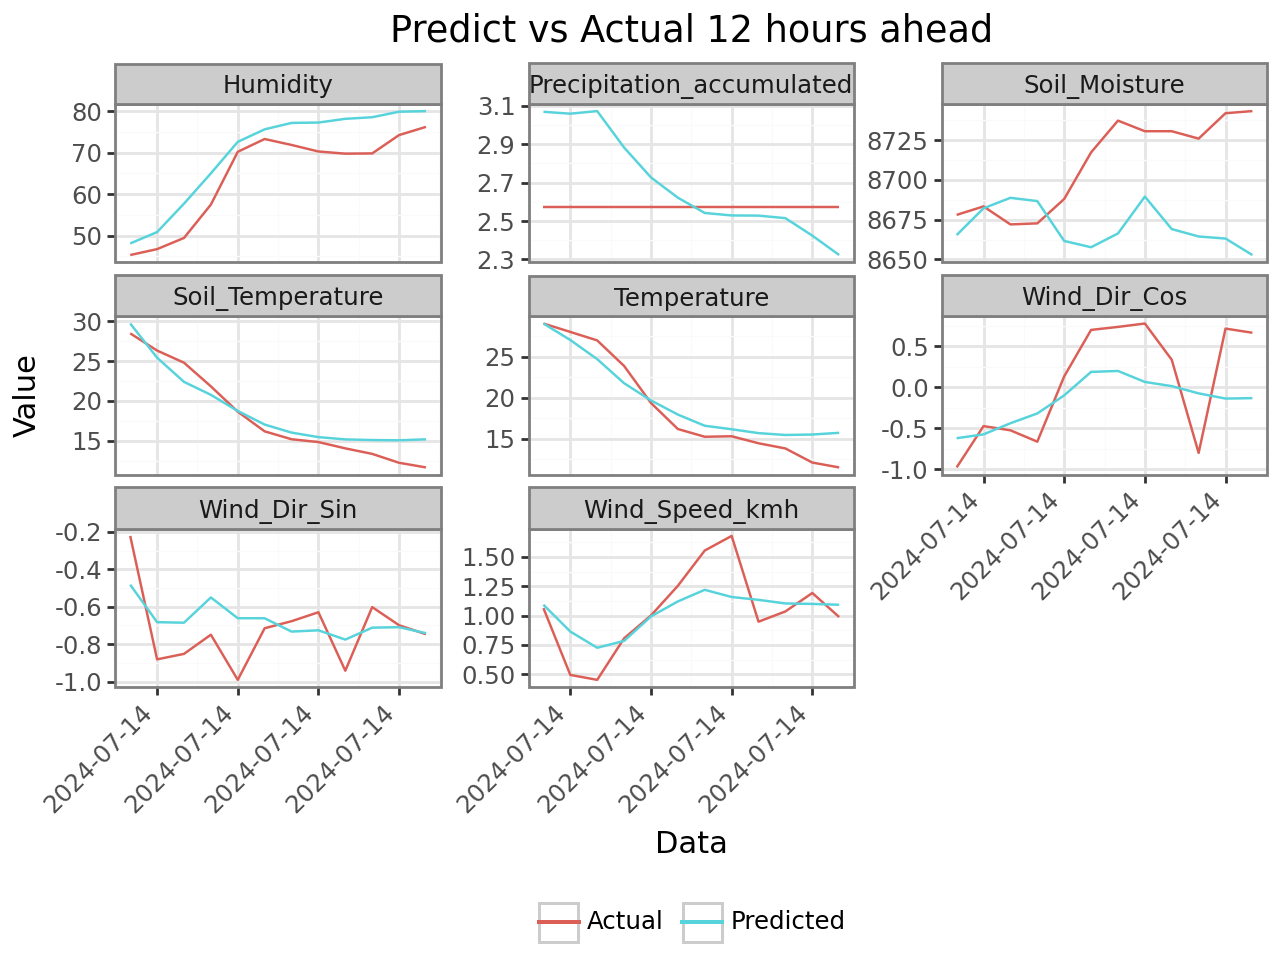

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/XGB/predict_12.png


{'Temperature': {'MSE': np.float64(4.181792019144226), 'RMSE': np.float64(2.0449430356721985), 'MAE': np.float64(1.681936698489718), 'R2': np.float64(0.8904236053738008), 'SMAPE': np.float64(10.227097315782796)}, 'Precipitation_accumulated': {'MSE': np.float64(0.07919139180030198), 'RMSE': np.float64(0.28140965122095934), 'MAE': np.float64(0.21445852518081665), 'R2': np.float64(-4.0154806139424674e+29), 'SMAPE': np.float64(7.901494883664067)}, 'Humidity': {'MSE': np.float64(35.949940591127415), 'RMSE': np.float64(5.995826931385479), 'MAE': np.float64(5.527369689941406), 'R2': np.float64(0.7018498811869306), 'SMAPE': np.float64(8.381725697475332)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.056073719656095644), 'RMSE': np.float64(0.23679890129832876), 'MAE': np.float64(0.17855403125286098), 'R2': np.float64(0.5371663727009262), 'SMAPE': np.float64(18.469471353414665)}, 'Soil_Moisture': {'MSE': np.float64(2804.9209409378327), 'RMSE': np.float64(52.96150433038919), 'MAE': np.float64(44.633707

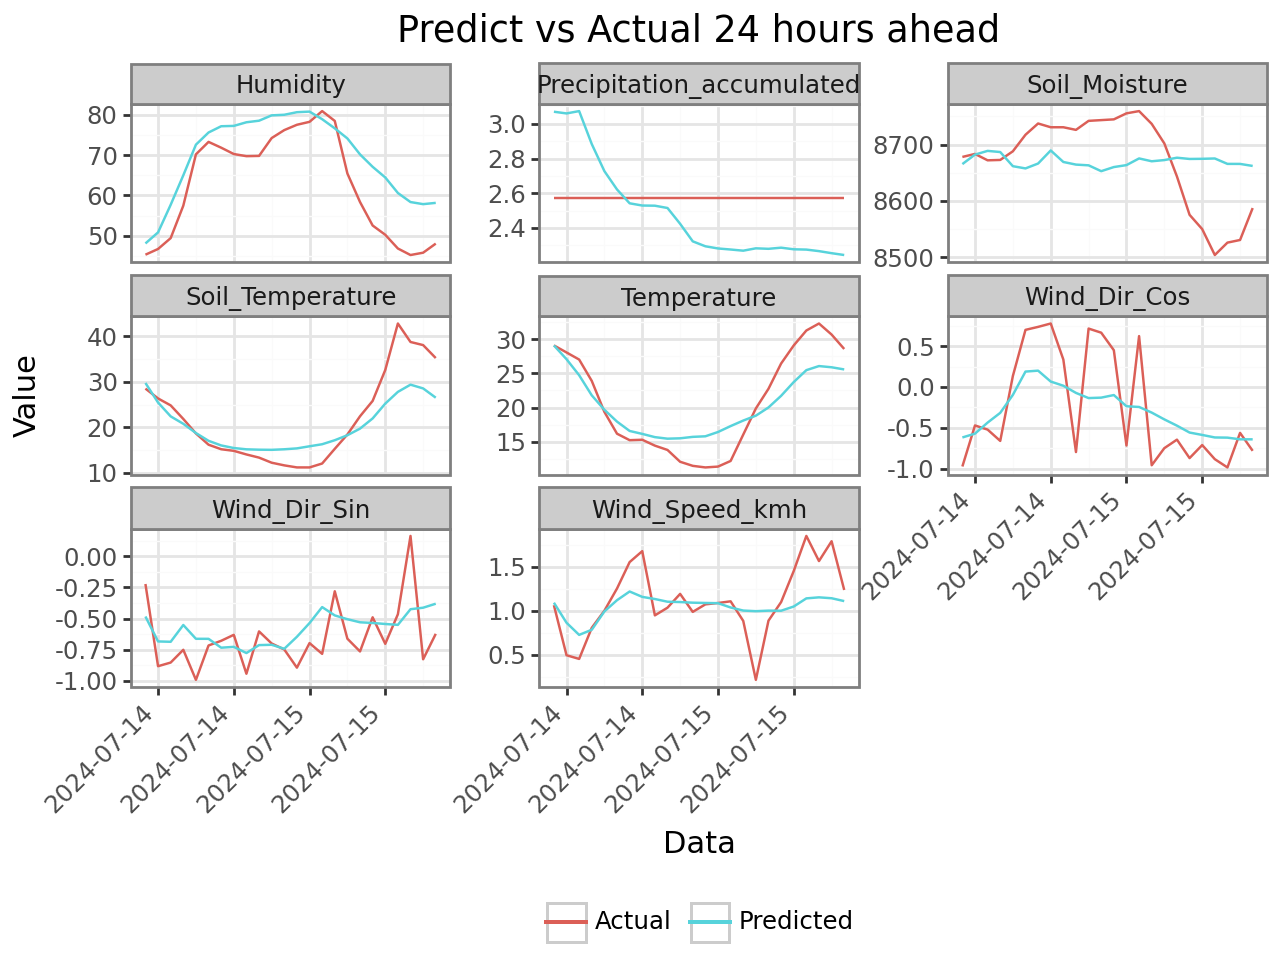

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/XGB/predict_24.png
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide


{'Temperature': {'MSE': np.float64(12.051309852989975), 'RMSE': np.float64(3.471499654758729), 'MAE': np.float64(2.936665563053554), 'R2': np.float64(0.7743711522528778), 'SMAPE': np.float64(15.274707277098358)}, 'Precipitation_accumulated': {'MSE': np.float64(0.08423995314860078), 'RMSE': np.float64(0.2902411982276134), 'MAE': np.float64(0.25648817369440335), 'R2': np.float64(-inf), 'SMAPE': np.float64(10.110775864152254)}, 'Humidity': {'MSE': np.float64(70.60343486254122), 'RMSE': np.float64(8.402585010729807), 'MAE': np.float64(7.258606137169732), 'R2': np.float64(0.5625952541322531), 'SMAPE': np.float64(11.911222717109858)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.10845769128447456), 'RMSE': np.float64(0.3293291534080677), 'MAE': np.float64(0.23527872757779225), 'R2': np.float64(0.3109459763409106), 'SMAPE': np.float64(23.259996470776002)}, 'Soil_Moisture': {'MSE': np.float64(6695.28648286396), 'RMSE': np.float64(81.8247302645353), 'MAE': np.float64(69.56694878472224), 'R2': np.floa

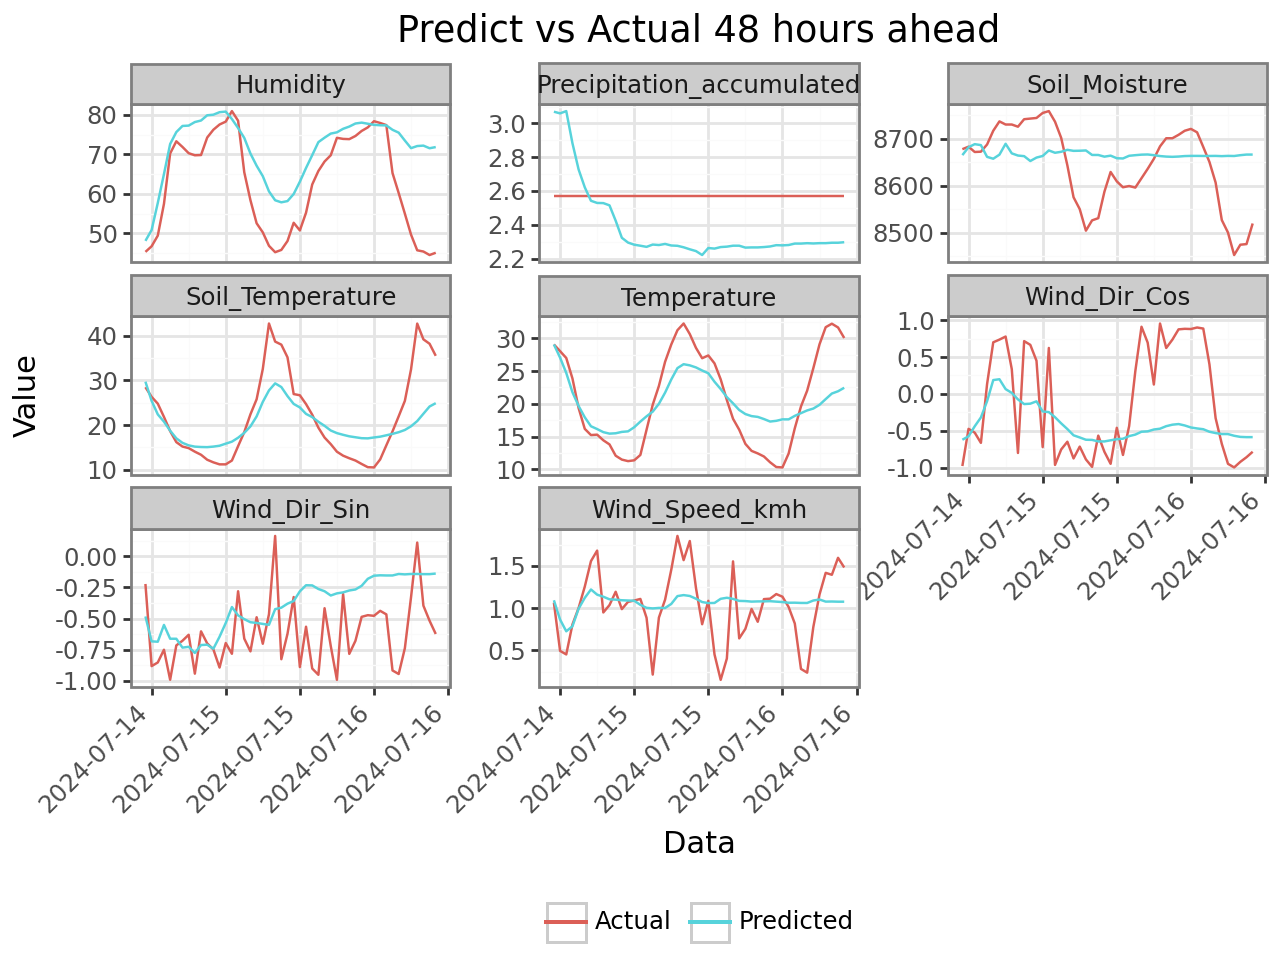

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/XGB/predict_48.png


{'Temperature': {'MSE': np.float64(23.534515639223326), 'RMSE': np.float64(4.851238567543687), 'MAE': np.float64(4.0074146135648085), 'R2': np.float64(0.5721043588685937), 'SMAPE': np.float64(20.744474592624417)}, 'Precipitation_accumulated': {'MSE': np.float64(0.08617689915664846), 'RMSE': np.float64(0.2935590215896089), 'MAE': np.float64(0.2764435502255828), 'R2': np.float64(-4.3696879176693206e+29), 'SMAPE': np.float64(11.169416031329005)}, 'Humidity': {'MSE': np.float64(130.69115897696784), 'RMSE': np.float64(11.43202339819893), 'MAE': np.float64(8.747138648562961), 'R2': np.float64(0.14336325563796537), 'SMAPE': np.float64(14.20999584700076)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.14899982717030527), 'RMSE': np.float64(0.3860049574426542), 'MAE': np.float64(0.2878965024981234), 'R2': np.float64(0.12658586000739613), 'SMAPE': np.float64(31.750323374474032)}, 'Soil_Moisture': {'MSE': np.float64(7994.529709997), 'RMSE': np.float64(89.41213401992484), 'MAE': np.float64(72.41787380642

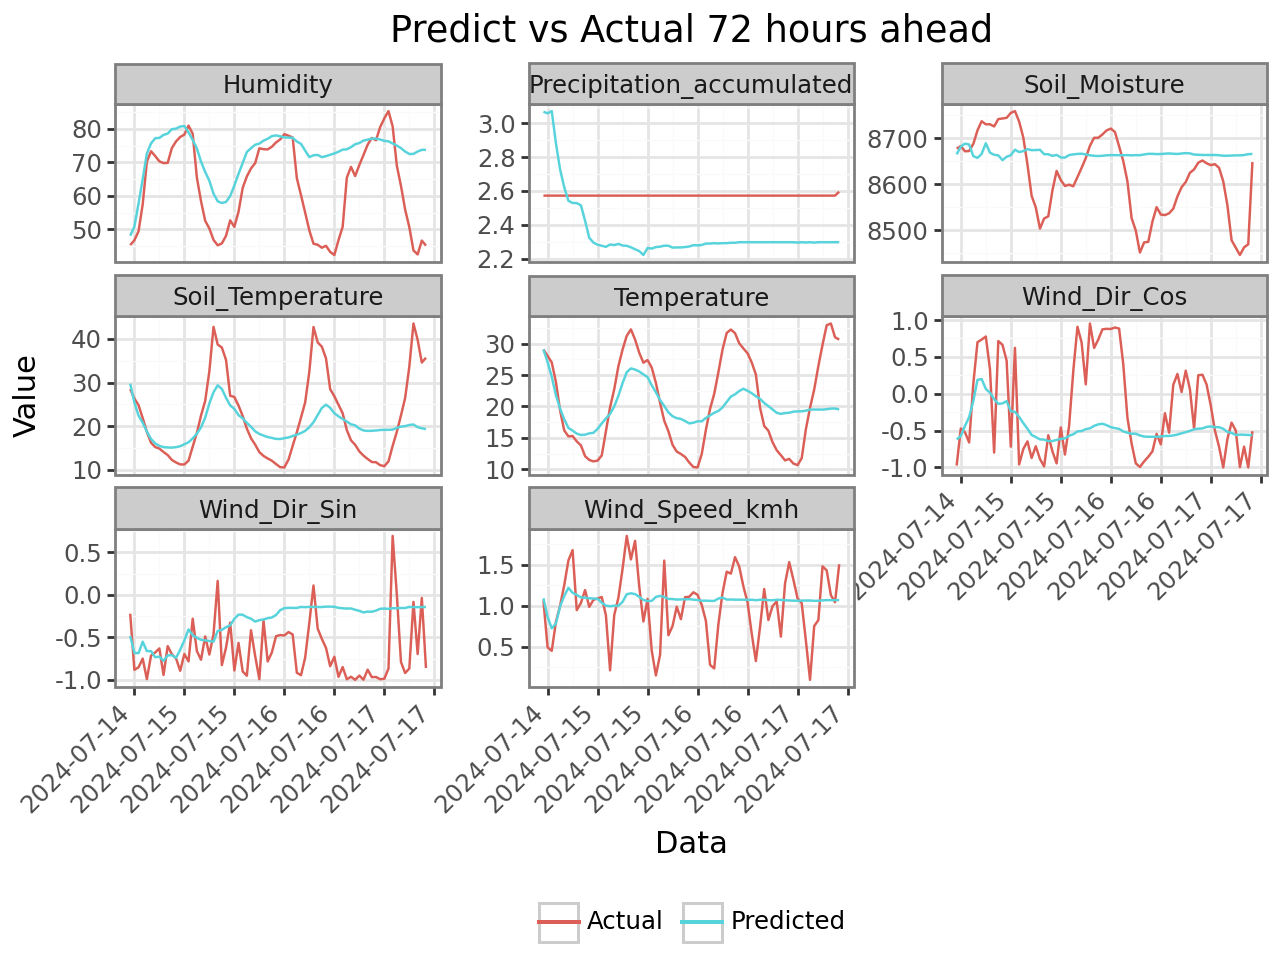

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/XGB/predict_72.png


{'Temperature': {'MSE': np.float64(34.34383818831582), 'RMSE': np.float64(5.860361609006378), 'MAE': np.float64(4.887555650605095), 'R2': np.float64(0.401624179512313), 'SMAPE': np.float64(24.86626391556336)}, 'Precipitation_accumulated': {'MSE': np.float64(0.0830673588878789), 'RMSE': np.float64(0.288214085165661), 'MAE': np.float64(0.2766877582458292), 'R2': np.float64(-11186.852577959333), 'SMAPE': np.float64(11.240592763752684)}, 'Humidity': {'MSE': np.float64(193.66310235038196), 'RMSE': np.float64(13.91628910127919), 'MAE': np.float64(10.57588961565936), 'R2': np.float64(-0.12503773774937899), 'SMAPE': np.float64(17.096397964517635)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.14504601531834707), 'RMSE': np.float64(0.38084907157343456), 'MAE': np.float64(0.28746241696454855), 'R2': np.float64(0.08055254456639405), 'SMAPE': np.float64(31.92196577514383)}, 'Soil_Moisture': {'MSE': np.float64(9732.16746298767), 'RMSE': np.float64(98.65174840309558), 'MAE': np.float64(79.20532226562503),

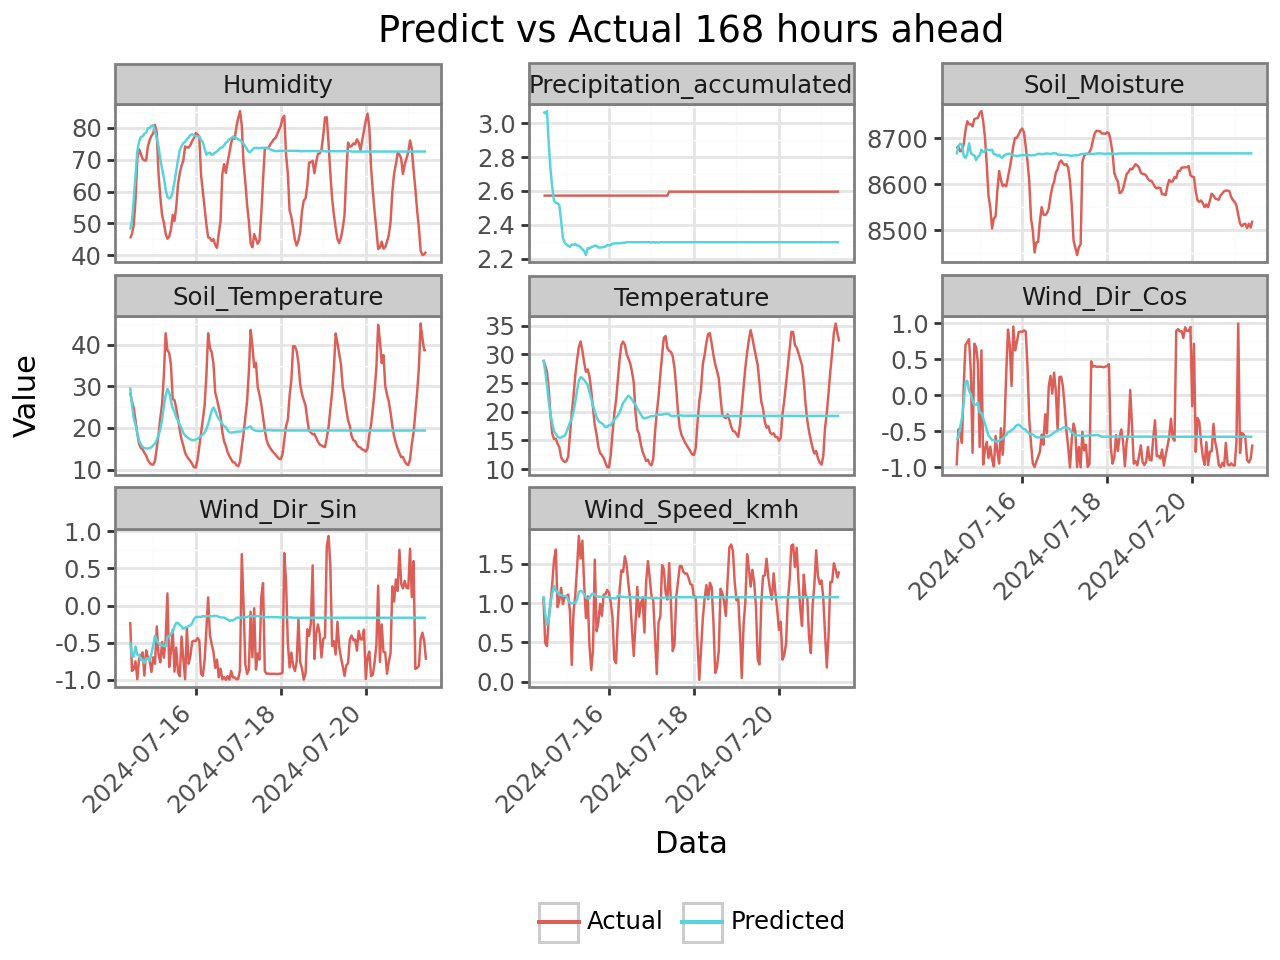

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/XGB/predict_168.png


{'Temperature': {'MSE': np.float64(49.839402549363385), 'RMSE': np.float64(7.059702723866168), 'MAE': np.float64(5.78775697942764), 'R2': np.float64(0.08824557381696763), 'SMAPE': np.float64(27.445031713401125)}, 'Precipitation_accumulated': {'MSE': np.float64(0.08676080726531213), 'RMSE': np.float64(0.29455187533830457), 'MAE': np.float64(0.2895616875052768), 'R2': np.float64(-654.8760209765927), 'SMAPE': np.float64(11.806864138732045)}, 'Humidity': {'MSE': np.float64(240.8124611956799), 'RMSE': np.float64(15.518133302548986), 'MAE': np.float64(11.759331579056996), 'R2': np.float64(-0.3515059958796627), 'SMAPE': np.float64(18.960201655182136)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.1683049439254398), 'RMSE': np.float64(0.4102498554849712), 'MAE': np.float64(0.3175006416818452), 'R2': np.float64(0.030646419996097407), 'SMAPE': np.float64(35.40962263715162)}, 'Soil_Moisture': {'MSE': np.float64(7799.1735025953385), 'RMSE': np.float64(88.3129294191702), 'MAE': np.float64(73.556408110119

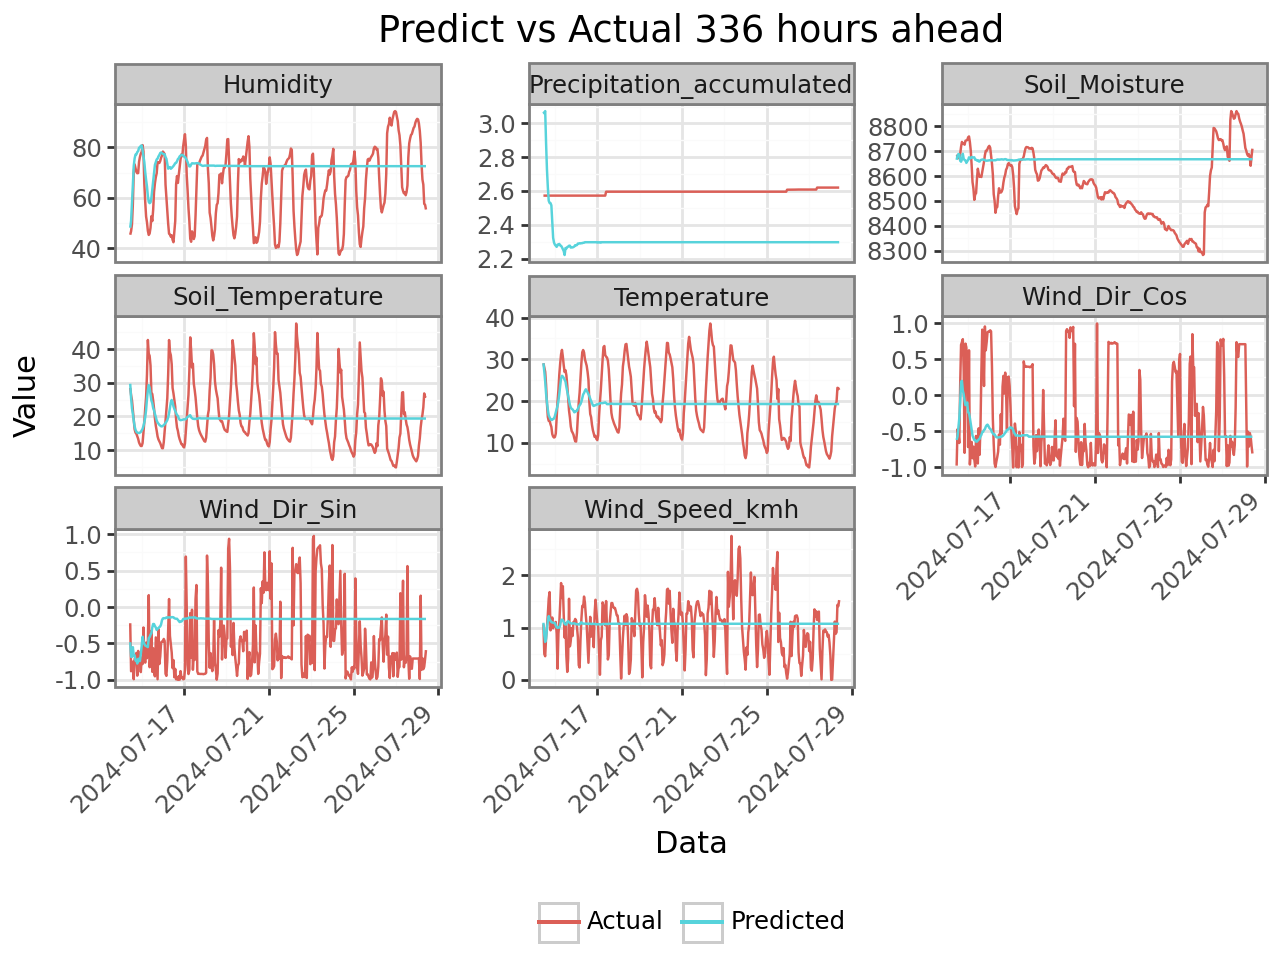

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/XGB/predict_336.png


{'Temperature': {'MSE': np.float64(58.9971542676887), 'RMSE': np.float64(7.680960504239604), 'MAE': np.float64(6.336090766911024), 'R2': np.float64(0.07970422545607003), 'SMAPE': np.float64(33.94169386280529)}, 'Precipitation_accumulated': {'MSE': np.float64(0.09008271218766262), 'RMSE': np.float64(0.3001378219879371), 'MAE': np.float64(0.29752372610816064), 'R2': np.float64(-521.0814240443034), 'SMAPE': np.float64(12.139028447515642)}, 'Humidity': {'MSE': np.float64(254.5811185162774), 'RMSE': np.float64(15.95559834403829), 'MAE': np.float64(12.408579620311652), 'R2': np.float64(-0.21164971705494695), 'SMAPE': np.float64(19.525290024728754)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.25152041452480073), 'RMSE': np.float64(0.5015181098672318), 'MAE': np.float64(0.39237483543834), 'R2': np.float64(0.005419189392820489), 'SMAPE': np.float64(43.09312775956615)}, 'Soil_Moisture': {'MSE': np.float64(28707.011503537713), 'RMSE': np.float64(169.43143599561952), 'MAE': np.float64(136.551360098763

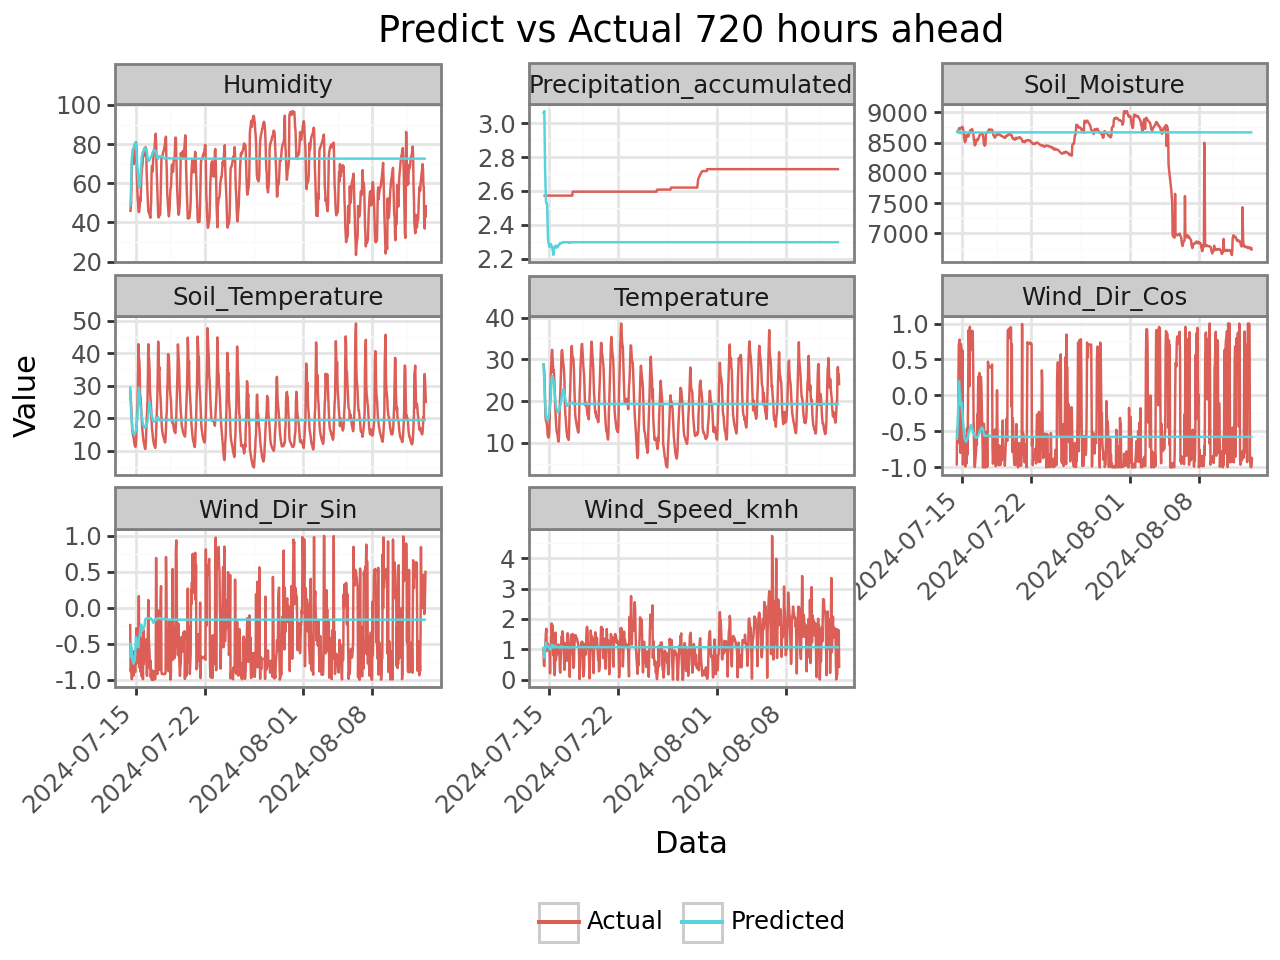

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/XGB/predict_720.png


{'Temperature': {'MSE': np.float64(48.21934064482758), 'RMSE': np.float64(6.944014735355015), 'MAE': np.float64(5.747235090226234), 'R2': np.float64(0.043988121956114346), 'SMAPE': np.float64(30.03035263784846)}, 'Precipitation_accumulated': {'MSE': np.float64(0.13675369529513975), 'RMSE': np.float64(0.3698022380883325), 'MAE': np.float64(0.36289175817634567), 'R2': np.float64(-29.93747192965411), 'SMAPE': np.float64(14.59838799447927)}, 'Humidity': {'MSE': np.float64(348.74213876902945), 'RMSE': np.float64(18.67463891937484), 'MAE': np.float64(14.8347511051368), 'R2': np.float64(-0.30192262086514265), 'SMAPE': np.float64(23.928929814648775)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.4569888112310013), 'RMSE': np.float64(0.6760094756961631), 'MAE': np.float64(0.5229723427449862), 'R2': np.float64(-0.025460562716787427), 'SMAPE': np.float64(49.554875783468724)}, 'Soil_Moisture': {'MSE': np.float64(941085.9095451888), 'RMSE': np.float64(970.0958249292638), 'MAE': np.float64(604.04072183294

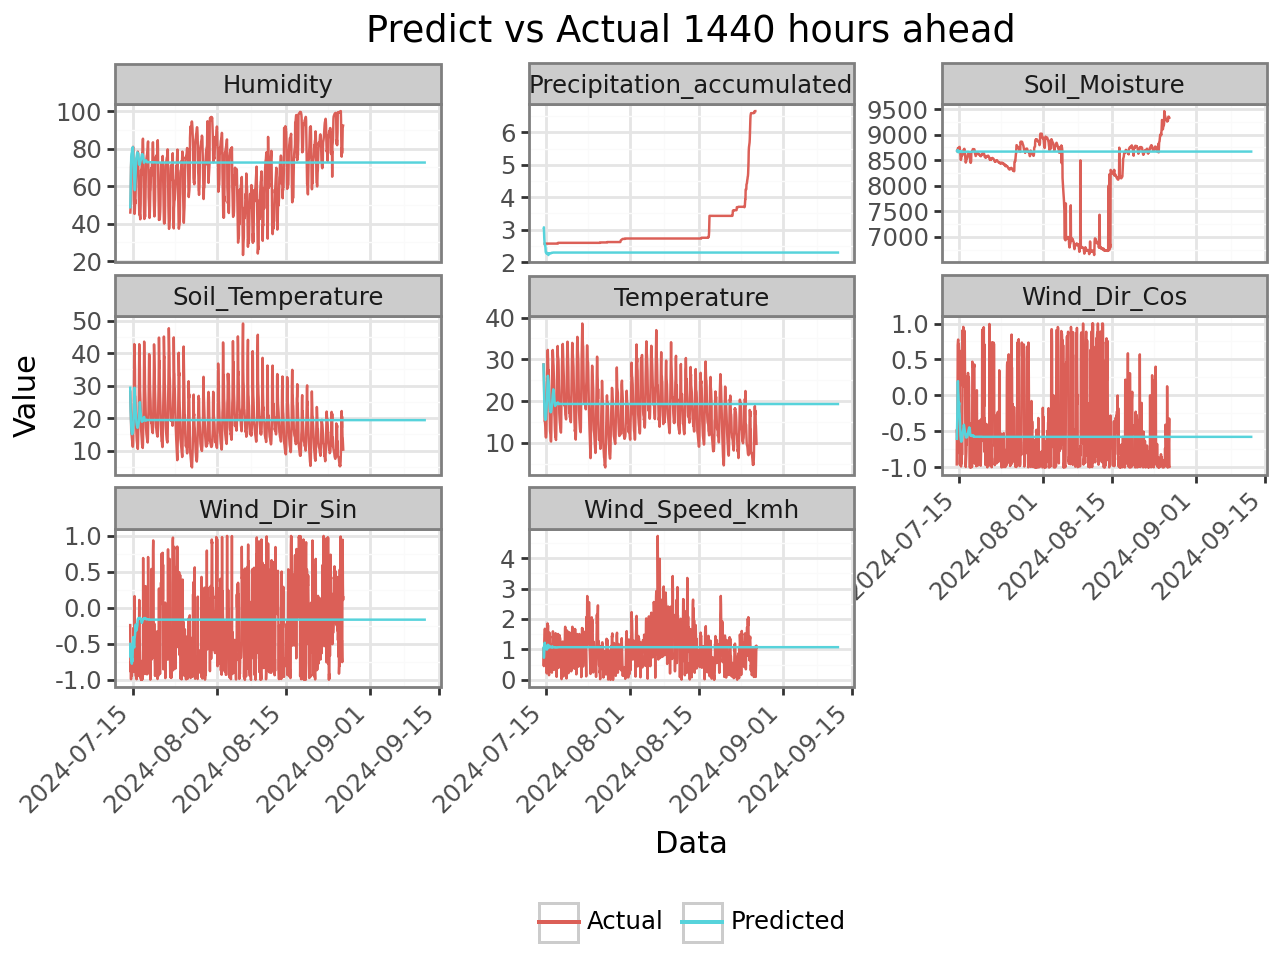

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/XGB/predict_1440.png


{'Temperature': {'MSE': np.float64(49.57928127011447), 'RMSE': np.float64(7.041255660044909), 'MAE': np.float64(5.867147703574645), 'R2': np.float64(0.014326978707482785), 'SMAPE': np.float64(33.17321443512297)}, 'Precipitation_accumulated': {'MSE': np.float64(1.0862484491220736), 'RMSE': np.float64(1.0422324352667565), 'MAE': np.float64(0.6843218421478816), 'R2': np.float64(-0.759034744283207), 'SMAPE': np.float64(23.240690988690734)}, 'Humidity': {'MSE': np.float64(319.8603631658846), 'RMSE': np.float64(17.884640425960054), 'MAE': np.float64(14.523416284762806), 'R2': np.float64(-0.029423123559680464), 'SMAPE': np.float64(21.983087129061488)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.415623652134379), 'RMSE': np.float64(0.6446888025507959), 'MAE': np.float64(0.5008094818619653), 'R2': np.float64(0.0016010726167935418), 'SMAPE': np.float64(51.16601642164705)}, 'Soil_Moisture': {'MSE': np.float64(769059.7804137869), 'RMSE': np.float64(876.9605352658618), 'MAE': np.float64(530.05660502145

In [7]:
m = "XGB"
for i in [3,6,12,24,48,72,168,336,720,1440]:
    pred = model.predict(
        series=best_train_scaled,
        n=i,
        verbose=True
    )

    metrics={}

    pred_t = best_scaler.inverse_transform(pred)
    pred_df = pred_t.to_dataframe()
    pred_df = pred_df.reset_index()
    pred_df = pred_df.rename(columns={"time": "Timestamp"})
    plot_columns = ['Timestamp'] + target_columns
    pred_melted = pred_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    pred_melted['type'] = 'Predicted'

    # Get validation data for comparison
    val_t = best_scaler.inverse_transform(best_val_scaled[:i])
    val_df = val_t.to_dataframe()
    val_df = val_df.reset_index()
    val_df = val_df.rename(columns={"time": "Timestamp"})
    val_melted = val_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    val_melted['type'] = 'Actual'

    # Combine predicted and validation data
    combined_df = pd.concat([pred_melted, val_melted])

    plot = (
        ggplot(combined_df, aes(x='Timestamp', y='value', color='type'))
        + geom_line()
        + facet_wrap('~ target_column', scales='free_y')
        + labs(
            title=f'Predict vs Actual {i} hours ahead',
            x='Data',
            y='Value',
            color='Data type'
        )
        + theme_bw()
        + theme(
            axis_text_x=element_text(rotation=45, hjust=1),
            legend_position='bottom',
            legend_title=element_blank(),

        )
    )
    plot.show()
    plot.save(f'results/{m}/predict_{i}.png', width=12, height=10, dpi=300)


    s = best_scaler.inverse_transform(best_val_scaled[:i])
    for target in target_columns:
        metrics[target] = {
            'MSE': mse(s[target], pred_t[target]),
            'RMSE': rmse(s[target], pred_t[target]),
            'MAE': mae(s[target], pred_t[target]),
            'R2': r2_score(s[target], pred_t[target]),
            'SMAPE': smape(s[target], pred_t[target]),
        }
    print(metrics)
    with open(f'results/{m}/metrics{i}.json', 'w') as f:
        json.dump(metrics, f, indent=4)


In [8]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)